In [2]:
import numpy as np
from matplotlib import pyplot as plt

#Get data without last column (z-error)
data=np.genfromtxt('galaxyquasar.csv', delimiter=',',skip_header=1,usecols=(0,1,2,3,4,6),dtype=float)

#Get true labels
labels = np.genfromtxt('galaxyquasar.csv', delimiter=',', skip_header=1, usecols=(5), dtype=str)

ug_set = data[:,0] - data[:, 1]
gr_set = data[:, 1] - data[:, 2]
ri_set = data[:, 2] - data[:, 3]
iz_set = data[:, 3] - data[:, 4]
labels = np.array([1 if label == 'QSO' else 0 for label in labels])
names = ["ug_set", "gr_set", "ri_set", "iz_set"]

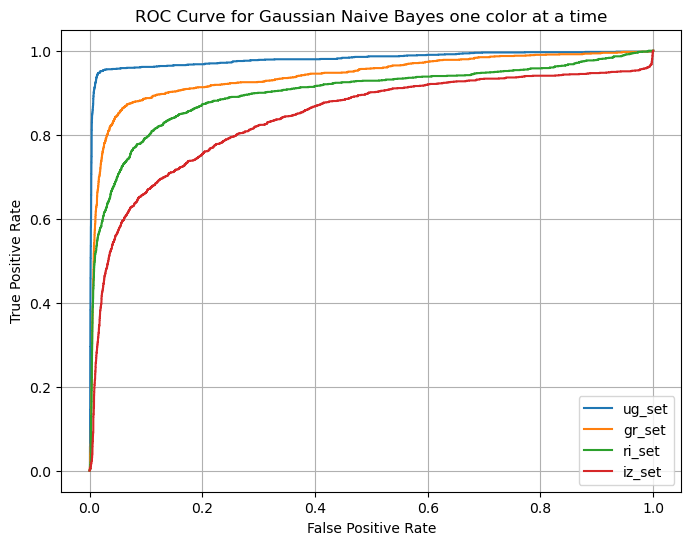

In [ ]:

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split

X_tot = np.column_stack((ug_set,gr_set,ri_set,iz_set))

fig1, ax1 = plt.subplots(figsize=(8, 6))

for j in range(4):
    X = X_tot[:, j:j+1] # Select one color at a time
    X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)[:, 1]
    fpr_gnb, tpr_gnb, thresh_gnb = roc_curve(y_test, y_prob)
    ax1.plot(fpr_gnb, tpr_gnb, label=f'{names[j]}')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve for Gaussian Naive Bayes one color at a time')
ax1.legend()
ax1.grid()


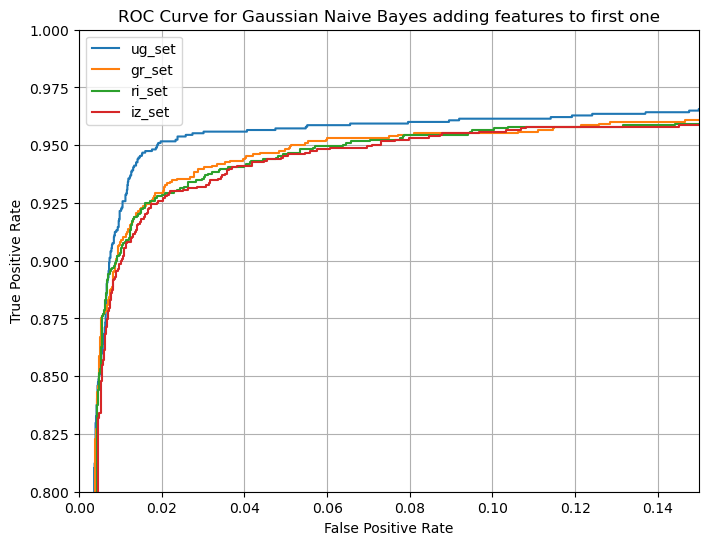

In [6]:
#So first feature seems to be the most important one, let's see if adding more features improves the results

fig2, ax2 = plt.subplots(figsize=(8, 6))

for j in range(4):
    X = X_tot[:, :j+1] # Select one color at a time
    X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)[:, 1]
    fpr_gnb, tpr_gnb, thresh_gnb = roc_curve(y_test, y_prob)
    ax2.plot(fpr_gnb, tpr_gnb, label=f'{names[j]}')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_xlim([0, 0.15])
ax2.set_ylim([0.8, 1.0])
ax2.set_title('ROC Curve for Gaussian Naive Bayes adding features to first one')
ax2.legend()
ax2.grid()

In [ ]:
#As we can see, adding more features does not improve the results, so it would make sense to only use the first color